# Tarea 1 INF 395

Para las tareas se utilizará `Keras`, una libreria de Deep Learning de alto nivel para Python, con el reciente anuncio de Keras Core, uno puede escoger el backend de su preferencia, ya sea Pytorch, Tensorflow o JAX.

Para más Información pueden revisar la documentación oficial de Keras: https://keras.io/

In [1]:
#Para utilizar keras-core primero hay que instalar tensorflow o pytorch o jax
#pip install tensorflow

# una vez instalado nuestro backend podemos instalar keras-core
#Se recomienda correr el jupyter notebook en colab, ya que tiene acceso gratis a GPUS y también tiene ya instalado tensorflow, pytorch y jax, solo hace falta instalar keras-core.
!pip install -q keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 9.1 MB/s eta 0:00:00


## Integrantes:

Tarea desarrollada por Grupo 02, conformado por:

* Nombre: Joaquín	García, Rol 201973087-8.
* Nombre: Gabriel	Díaz, Rol 201973095-9.
* Nombre: Bruno	Liberona, Rol 201973013-4.

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

Using TensorFlow backend


## Helper Functions

In [3]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])

In [4]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [5]:
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm).plot()

## Parte 1: Demostración del uso de Keras

### 1.1 Mnist

Mnist es un dataset de imágenes de dígitos escritos a mano. Cada imagen es de 28x28 pixeles y está en escala de grises. El dataset está dividido en 60.000 imágenes de entrenamiento y 10.000 imágenes de testeo.

In [ ]:
#Cargamos el Dataset
# the 'x' component corresponds to the image
# while the 'y' component corresponds to the label
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#### Exploración de los Datos

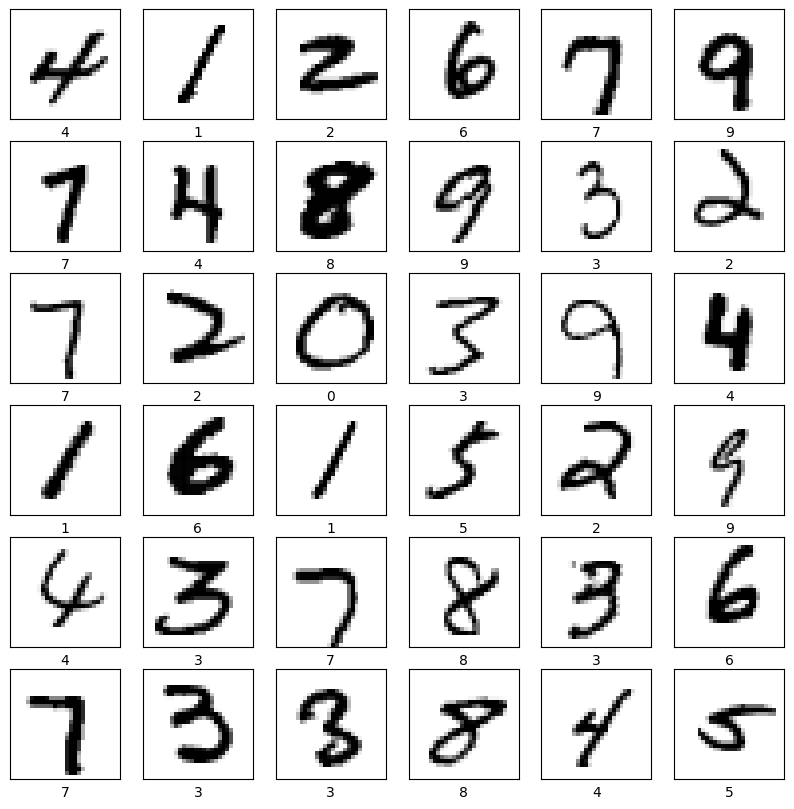

In [ ]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de clases:', num_classes)
print('Dimension de los datos:', input_shape)

cantidad de clases: 10
Dimension de los datos: (28, 28)


#### One Hot Encoding

In [ ]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [5 0 4 ... 5 6 8]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


#### Arquitectura de la red

In [ ]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 101,770 (3.11 MB)

 Trainable params: 101,770 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


#### Definición de hiperparámetros

In [ ]:
# definimos algunos hiperparámetros
batch_size = 128        #cantidad de imágenes por batch
epochs = 20             #cantidad de epochs
validation_split = 0.2  #Porcentaje de data destinada a validación

In [ ]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3) # gradient descent (with momentum)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

#### Entrenamiento del Modelo

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6077 - loss: 17.2967 - val_accuracy: 0.7898 - val_loss: 1.0557
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7962 - loss: 0.9616 - val_accuracy: 0.8378 - val_loss: 0.7853
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8409 - loss: 0.6901 - val_accuracy: 0.8591 - val_loss: 0.6569
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8647 - loss: 0.5500 - val_accuracy: 0.8724 - val_loss: 0.5855
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8799 - loss: 0.4683 - val_accuracy: 0.8839 - val_loss: 0.5360
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8914 - loss: 0.4117 - val_accuracy: 0.8911 - val_loss: 0.5022
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9014 - loss: 0.3691 - val_accuracy: 0.8976 - val_loss: 0.4756
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9085 - loss: 0.3359 - val_accuracy: 0

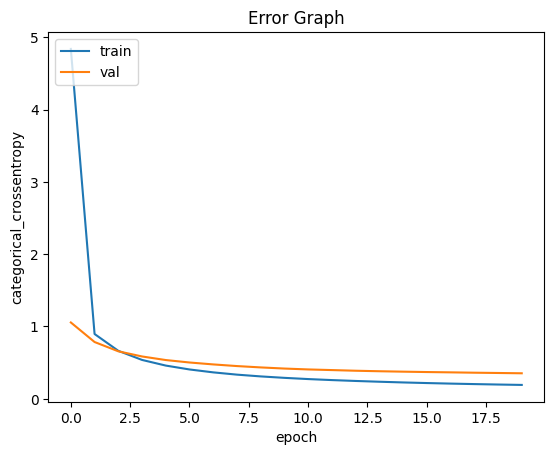

In [ ]:
plot_losses(history, loss)

#### Evaluación del Modelo

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.36799508333206177
Test accuracy: 0.9212999939918518


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


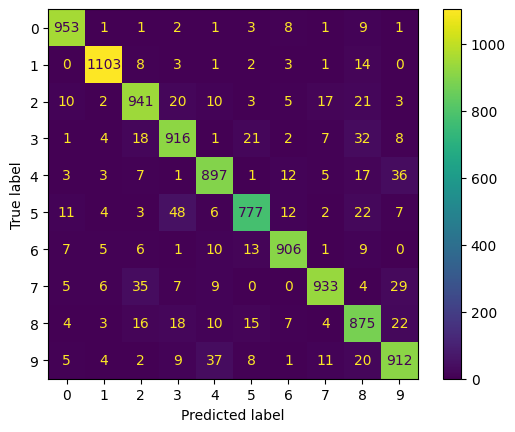

In [ ]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

### 1.2.1 Cifar10

Cifar10 es un dataset de imágenes de 32x32 pixeles, que contiene 10 clases distintas. Este dataset es muy utilizado para probar algoritmos de clasificación de imágenes. En este caso, utilizaremos una versión reducida de este dataset, que contiene 50000 imágenes de entrenamiento y 10000 imágenes de testeo, con 100 imágenes por clase. Las clases son: 'avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco' y 'camión'.

In [ ]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
#Visualizamos si el dataset es balanceado o no.
pd.value_counts(pd.Series(y_train.reshape(-1)))

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: count, dtype: int64

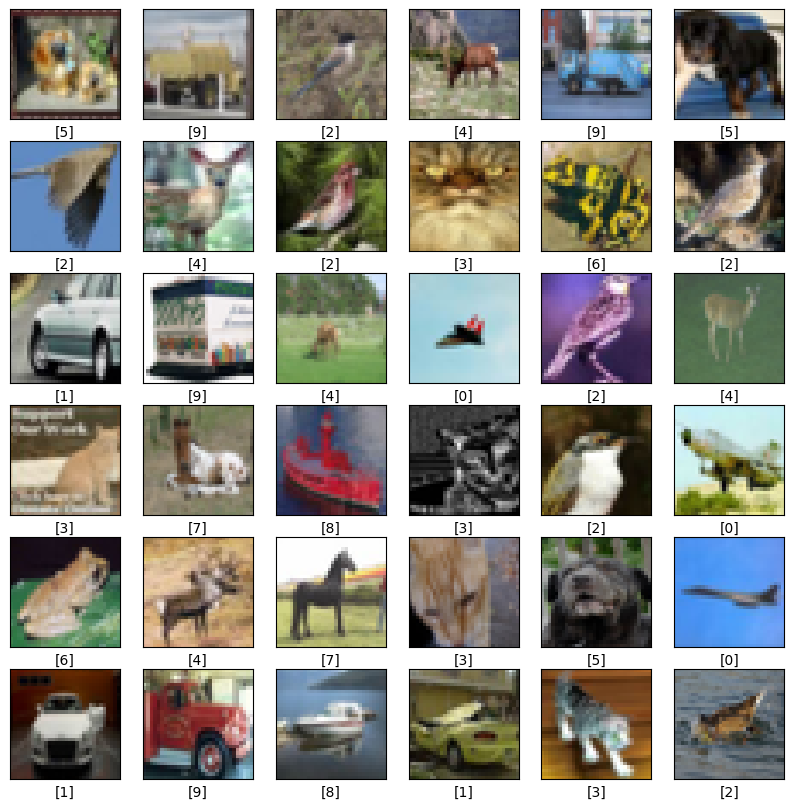

In [ ]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de imágenes:',x_train.shape[0])
print('Dimensión de los datos:',input_shape)
print('Tipo de Datos:',x_train.dtype)
print('cantidad de clases:', num_classes)

cantidad de imágenes: 50000
Dimensión de los datos: (32, 32, 3)
Tipo de Datos: uint8
cantidad de clases: 10


In [ ]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │    393,344 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 394,634 (12.04 MB)

 Trainable params: 394,634 (12.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
# definimos algunos hiperparámetros
batch_size = 128
epochs = 20
validation_split = 0.2

In [ ]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1021 - loss: 582.5866 - val_accuracy: 0.0953 - val_loss: 2.3144
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1018 - loss: 2.3032 - val_accuracy: 0.0953 - val_loss: 2.3126
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1017 - loss: 2.3021 - val_accuracy: 0.0954 - val_loss: 2.3128
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1019 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3130
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3125
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 

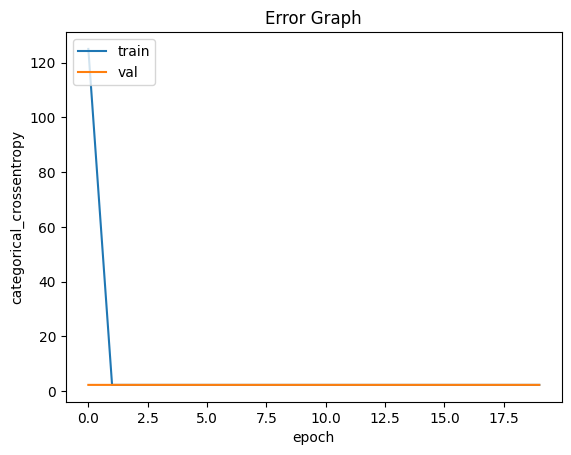

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.309175729751587
Test accuracy: 0.09969999641180038


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


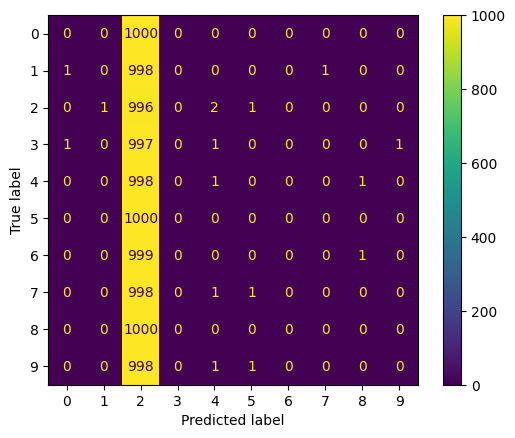

In [ ]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
# Comparamos otras métricas de clasificación como la precisión, recall y f1-score
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      1000
     class 1       0.00      0.00      0.00      1000
     class 2       0.10      1.00      0.18      1000
     class 3       0.00      0.00      0.00      1000
     class 4       0.17      0.00      0.00      1000
     class 5       0.00      0.00      0.00      1000
     class 6       0.00      0.00      0.00      1000
     class 7       0.00      0.00      0.00      1000
     class 8       0.00      0.00      0.00      1000
     class 9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.03      0.10      0.02     10000
weighted avg       0.03      0.10      0.02     10000



C:\Users\jgarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jgarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jgarc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469

Podemos observar como este simple modelo de redes neuronales no es lo suficientemente capaz de clasificar las imágenes, de hecho les asigna el mismo label a todas las imágenes.

Es por esto que saltan los warnings, porque al calcular f1, recall y precisión, no hay datos para las otras clases.

Ahora vamos a ver como podemos mejorar nuestro modelo.

### 1.2.2 Mejorando el Modelo

In [ ]:
#Es una práctica común en modelos de machine learning escalar nuestros datos, asi nos aseguramos de que todos tengan el mismo rango, con pequeños cambios como estos nuestros modelos pueden mejorar su desempeño.

#Escalamos las imágenes entre [0,1]
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 512)               │  1,573,376 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 10)                │        330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,748,266 (53.35 MB)

 Trainable params: 1,748,266 (53.35 MB)

 Non-trainable params: 0 (0.00 B)

**Explique cómo funciona la capa de Dropout dentro del modelo y por qué esta capa mejora las predicciones [3pts]**

`Respuesta:` La capa de Dropout dentro del modelo le asigna a cada una de las neuronas presentes en las capas ocultas una probabilidad de 0.1 (10%) de ser desactivadas durante el proceso de entrenamiento, lo cual implica que las neuronas afectadas por el "drop out" no van a verse implicadas ni en el forward pass ni en el backward pass de la epoch en la cual fueron desactivadas, es decir, no ejecutarán cálculos ni recibirán flujos de gradiente. De esta manera, se da una regularización del modelo de red neuronal que evita la co-adaptación de neuronas, y permite que cada neurona individual se vuelva más robusta y capaz de realizar predicciones significativas. El efecto final (y el más importante) de esta estrategia de regularización, es evitar el overfitting, pues se reduce la dependencia de la red hacia neuronas específicas, lo cual lleva a una mayor capacidad de generalización de patrones que puede ser observada mediante pruebas en el set de validación y testeo.

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
#Agregamos Callbacks
#Early Stopping monitorea la función de pérdida y detiene el entrenamiento cuando no hay mejora dentro de un número de épocas determinado, lo que nos ahorra tiempo de entrenamiento y también evita el sobreajuste.
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
#Cambiamos el Optimizador a Adam
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.Adam(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# agregamos más epoochs ahora que tenemos early stopping
batch_size = 128
epochs = 200
validation_split = 0.2

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.1530 - loss: 2.2533 - val_accuracy: 0.2879 - val_loss: 1.9160
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2859 - loss: 1.9281 - val_accuracy: 0.3340 - val_loss: 1.8416
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3251 - loss: 1.8424 - val_accuracy: 0.3767 - val_loss: 1.7567
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3525 - loss: 1.7783 - val_accuracy: 0.3775 - val_loss: 1.7290
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3692 - loss: 1.7403 - val_accuracy: 0.3817 - val_loss: 1.7021
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3792 - loss: 1.7110 - val_accuracy: 0.4089 - val_loss: 1.6588
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3962 - loss: 1.6793 - val_accuracy: 0.4130 - val_loss: 1.6414
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4079 - loss: 1.6545 - val_a

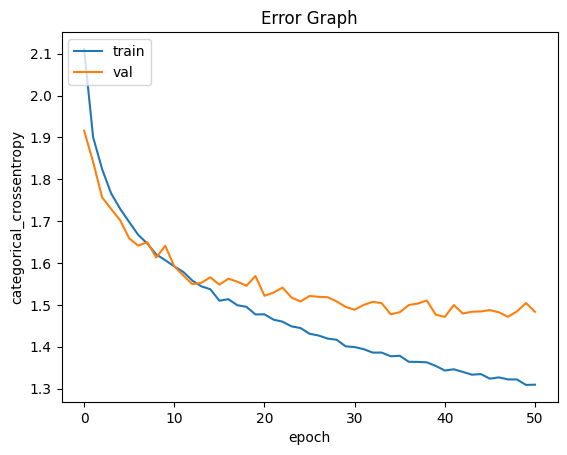

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4491504430770874
Test accuracy: 0.48820000886917114


Aún estamos con un accuracy del 0.5, eso seria equivalente a lanzar una moneda al aire y que salga cara o sello, por lo que no es un buen modelo, pero se puede mejorar.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


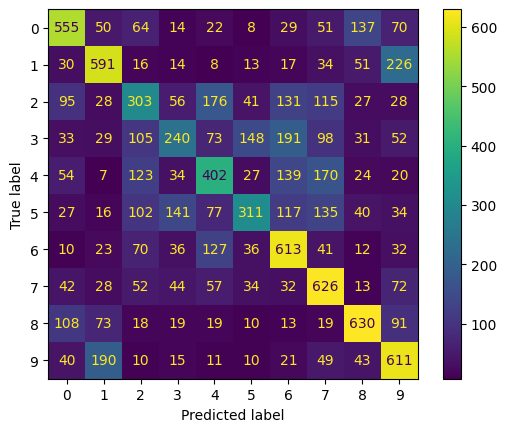

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.56      0.56      0.56      1000
     class 1       0.57      0.59      0.58      1000
     class 2       0.35      0.30      0.33      1000
     class 3       0.39      0.24      0.30      1000
     class 4       0.41      0.40      0.41      1000
     class 5       0.49      0.31      0.38      1000
     class 6       0.47      0.61      0.53      1000
     class 7       0.47      0.63      0.54      1000
     class 8       0.62      0.63      0.63      1000
     class 9       0.49      0.61      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000



### 1.2.3 Último Modelo ahora Con Convoluciones y Skip Connections

Keras nos permite complejizar el modelo de una manera muy sencilla, agregaremos capas convolucionales, ya que estas son muy buenas a la hora de trabajar con imágenes, también agregaremos skip connections que son conexiones que se saltan capas del modelo.

**EJEMPLO DE SKIP CONNECTION**

<img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png">

**¿Qué problema resuelven las Skip Connections y como lo hacen? [3pts]**

`Respuesta:` Principalmente, el problema que apuntan a resolver la Skip Connections es el del gradiente desvaneciente durante el proceso de backpropagation. Este problema se da cuando el gradiente utilizado para actualizar los parámetros de la red se vuelve excesivamente pequeño, y dejan de observarse mejoras en el entrenamiento. Las Skip Connections resuelven esto al permitir la propagación del gradiente desde las capas finales (más cercanas al output) directamente hacia las capas más tempranas de la red, permitiendo una convergencia más rápida y un entrenamiento más eficaz del modelo.

In [ ]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(inputs)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_1)
x_1 = keras.layers.Dropout(0.2)(x_1)
flatten_x1 = keras.layers.Flatten()(x_1)

x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_2)
x_2 = keras.layers.Dropout(0.2)(x_2)
flatten_x2 = keras.layers.Flatten()(x_2)

x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_3)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_3)
x_3 = keras.layers.Dropout(0.2)(x_3)
flatten_x3 = keras.layers.Flatten()(x_3)

z = keras.layers.concatenate([flatten_x1, flatten_x2])
z = keras.layers.concatenate([z, flatten_x3])

z =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(z)
outputs = keras.layers.Dense(num_classes, activation='softmax')(z)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     896 │ input_layer_3[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 32, 32,    │     128 │ conv2d[0][0]         │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │   9,248 │ batch_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │     128 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │       0 │ batch_normalization… │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │       0 │ max_pooling2d[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  18,496 │ dropout_4[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_2[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  36,928 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_3[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │       0 │ batch_normalization… │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 8, 64)  │       0 │ max_pooling2d_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │  73,856 │ dropout_5[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_4[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │ 147,584 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_5[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │       0 │ batch_normalization

 Total params: 7,804,234 (238.17 MB)

 Trainable params: 7,803,338 (238.14 MB)

 Non-trainable params: 896 (28.00 KB)

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
#Cambiamos el Optimizador a AdamW
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics, jit_compile=True)

In [ ]:
#Early Stopping
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
# Hiperparámetros
batch_size = 128
epochs = 200
validation_split = 0.2

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 173s 523ms/step - accuracy: 0.2279 - loss: 2.6779 - val_accuracy: 0.2785 - val_loss: 1.9365
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 162s 515ms/step - accuracy: 0.4627 - loss: 1.4837 - val_accuracy: 0.5610 - val_loss: 1.2516
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 503ms/step - accuracy: 0.5804 - loss: 1.1924 - val_accuracy: 0.6248 - val_loss: 1.1232
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 159s 506ms/step - accuracy: 0.6688 - loss: 0.9743 - val_accuracy: 0.6967 - val_loss: 0.8920
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 159s 506ms/step - accuracy: 0.7278 - loss: 0.8101 - val_accuracy: 0.7366 - val_loss: 0.7909
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 502ms/step - accuracy: 0.7624 - loss: 0.6991 - val_accuracy: 0.7511 - val_loss: 0.7637
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 504ms/step - accuracy: 0.7994 - loss: 0.5848 - val_accuracy: 0.7374 - val_loss: 0.8753
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 502ms/step - accuracy: 

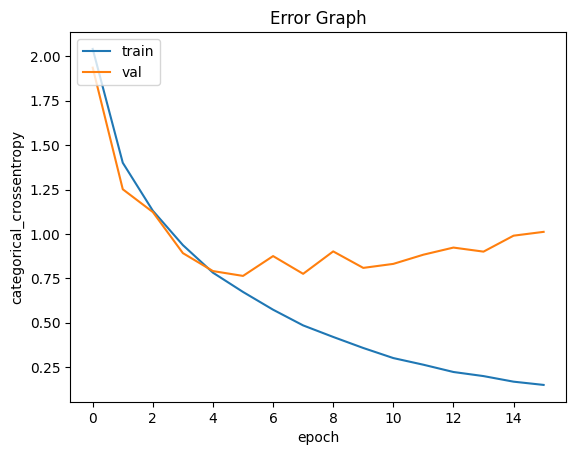

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.77323979139328
Test accuracy: 0.7455000281333923


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


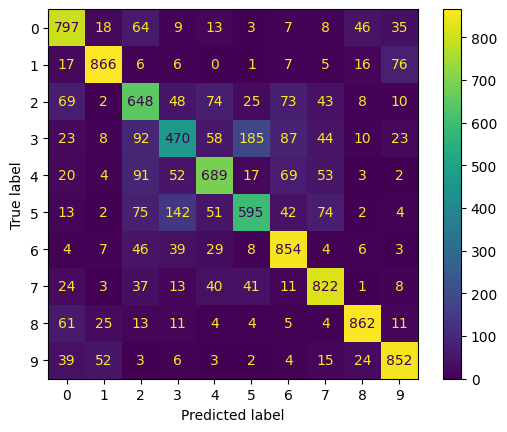

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.75      0.80      0.77      1000
     class 1       0.88      0.87      0.87      1000
     class 2       0.60      0.65      0.62      1000
     class 3       0.59      0.47      0.52      1000
     class 4       0.72      0.69      0.70      1000
     class 5       0.68      0.59      0.63      1000
     class 6       0.74      0.85      0.79      1000
     class 7       0.77      0.82      0.79      1000
     class 8       0.88      0.86      0.87      1000
     class 9       0.83      0.85      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.74      0.75      0.74     10000
weighted avg       0.74      0.75      0.74     10000



Ahora ya tenemos resultados aceptables, pero esta no es la única forma de mejorar nuestro modelo, si ya conocemos alguna arquitectura del estado del arte para nuestra tarea podemos simplemente importar un modelo, congelarlo y reemplazar la última capa para que se ajuste a nuestro problema. Esto se llama `Transfer Learning` y es una de las formas más usadas para entrenar redes neuronales en la actualidad, ya que nos ahorra mucho tiempo de entrenamiento y nos permite usar modelos que ya han sido probados y que sabemos que funcionan bien.

### 1.2.4 Transfer Learning

In [ ]:
pre_trained_mobilenet = keras.applications.VGG16(input_shape=input_shape,include_top=False) #Cargamos la red pre-entrenada, sin la capa densa final, ya que queremos adaptar esta red a nuestro dataset.

#Agregamos una capa de GlobalAveragePooling2D para reducir la dimensionalidad de la salida de la red pre-entrenada y la capa de salida.
x = pre_trained_mobilenet.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=pre_trained_mobilenet.input, outputs=outputs)

for layer in pre_trained_mobilenet.layers: #Tenemos que explicitar que no queremos entrenar las capas de la red pre-entrenada.
    layer.trainable = False

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)        │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 512)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 10)                │      5,130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,719,818 (449.21 MB)

 Trainable params: 5,130 (160.31 KB)

 Non-trainable params: 14,714,688 (449.06 MB)

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
#Cambiamos el Optimizador
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 305s 974ms/step - accuracy: 0.5936 - loss: 1.1910 - val_accuracy: 0.5760 - val_loss: 1.2328
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 290s 926ms/step - accuracy: 0.5978 - loss: 1.1833 - val_accuracy: 0.5776 - val_loss: 1.2270
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 301s 960ms/step - accuracy: 0.6005 - loss: 1.1755 - val_accuracy: 0.5786 - val_loss: 1.2221
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 298s 950ms/step - accuracy: 0.6027 - loss: 1.1686 - val_accuracy: 0.5799 - val_loss: 1.2179
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 310s 991ms/step - accuracy: 0.6044 - loss: 1.1623 - val_accuracy: 0.5808 - val_loss: 1.2142
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 306s 977ms/step - accuracy: 0.6057 - loss: 1.1567 - val_accuracy: 0.5826 - val_loss: 1.2111
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 306s 976ms/step - accuracy: 0.6075 - loss: 1.1516 - val_accuracy: 0.5836 - val_loss: 1.2083
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.6

KeyboardInterrupt: 

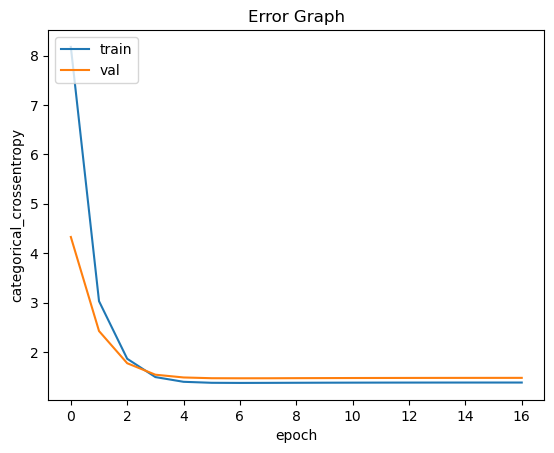

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4544460773468018
Test accuracy: 0.5475999712944031


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


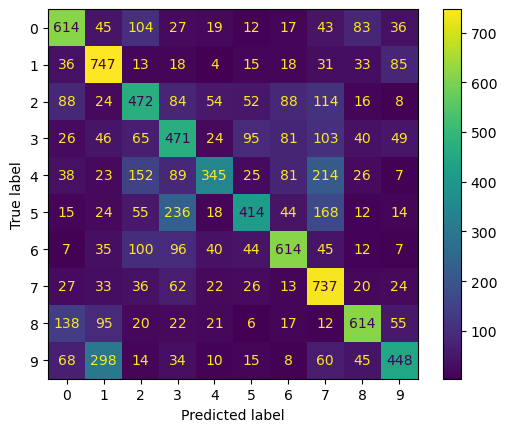

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.58      0.61      0.60      1000
     class 1       0.55      0.75      0.63      1000
     class 2       0.46      0.47      0.46      1000
     class 3       0.41      0.47      0.44      1000
     class 4       0.62      0.34      0.44      1000
     class 5       0.59      0.41      0.49      1000
     class 6       0.63      0.61      0.62      1000
     class 7       0.48      0.74      0.58      1000
     class 8       0.68      0.61      0.65      1000
     class 9       0.61      0.45      0.52      1000

    accuracy                           0.55     10000
   macro avg       0.56      0.55      0.54     10000
weighted avg       0.56      0.55      0.54     10000



Podemos observar cómo no obtenemos resultados tan buenos como la red anterior pero hay que tener en cuenta que implementamos una arquitectura en menos de 5 lineas, desde cargar el modelo, agregar una capa de max pooling y finalmente la capa de salida.

## Parte 2: Datset Guiado

### 2.1 Exploracion de la Data

In [122]:
df = pd.read_csv('Steel_industry_data.csv')

In [65]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


Siempre es bueno revisar los datos que tenemos, ver si existen datos faltantes, el tipo de dato de cada columna, etc.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

**Realice un pequeño EDA (Exploratory Data Analisys) del Dataset, mostrando algunos gráficos como el que se presenta a continuación, y comente lo que observa. [3pts]**

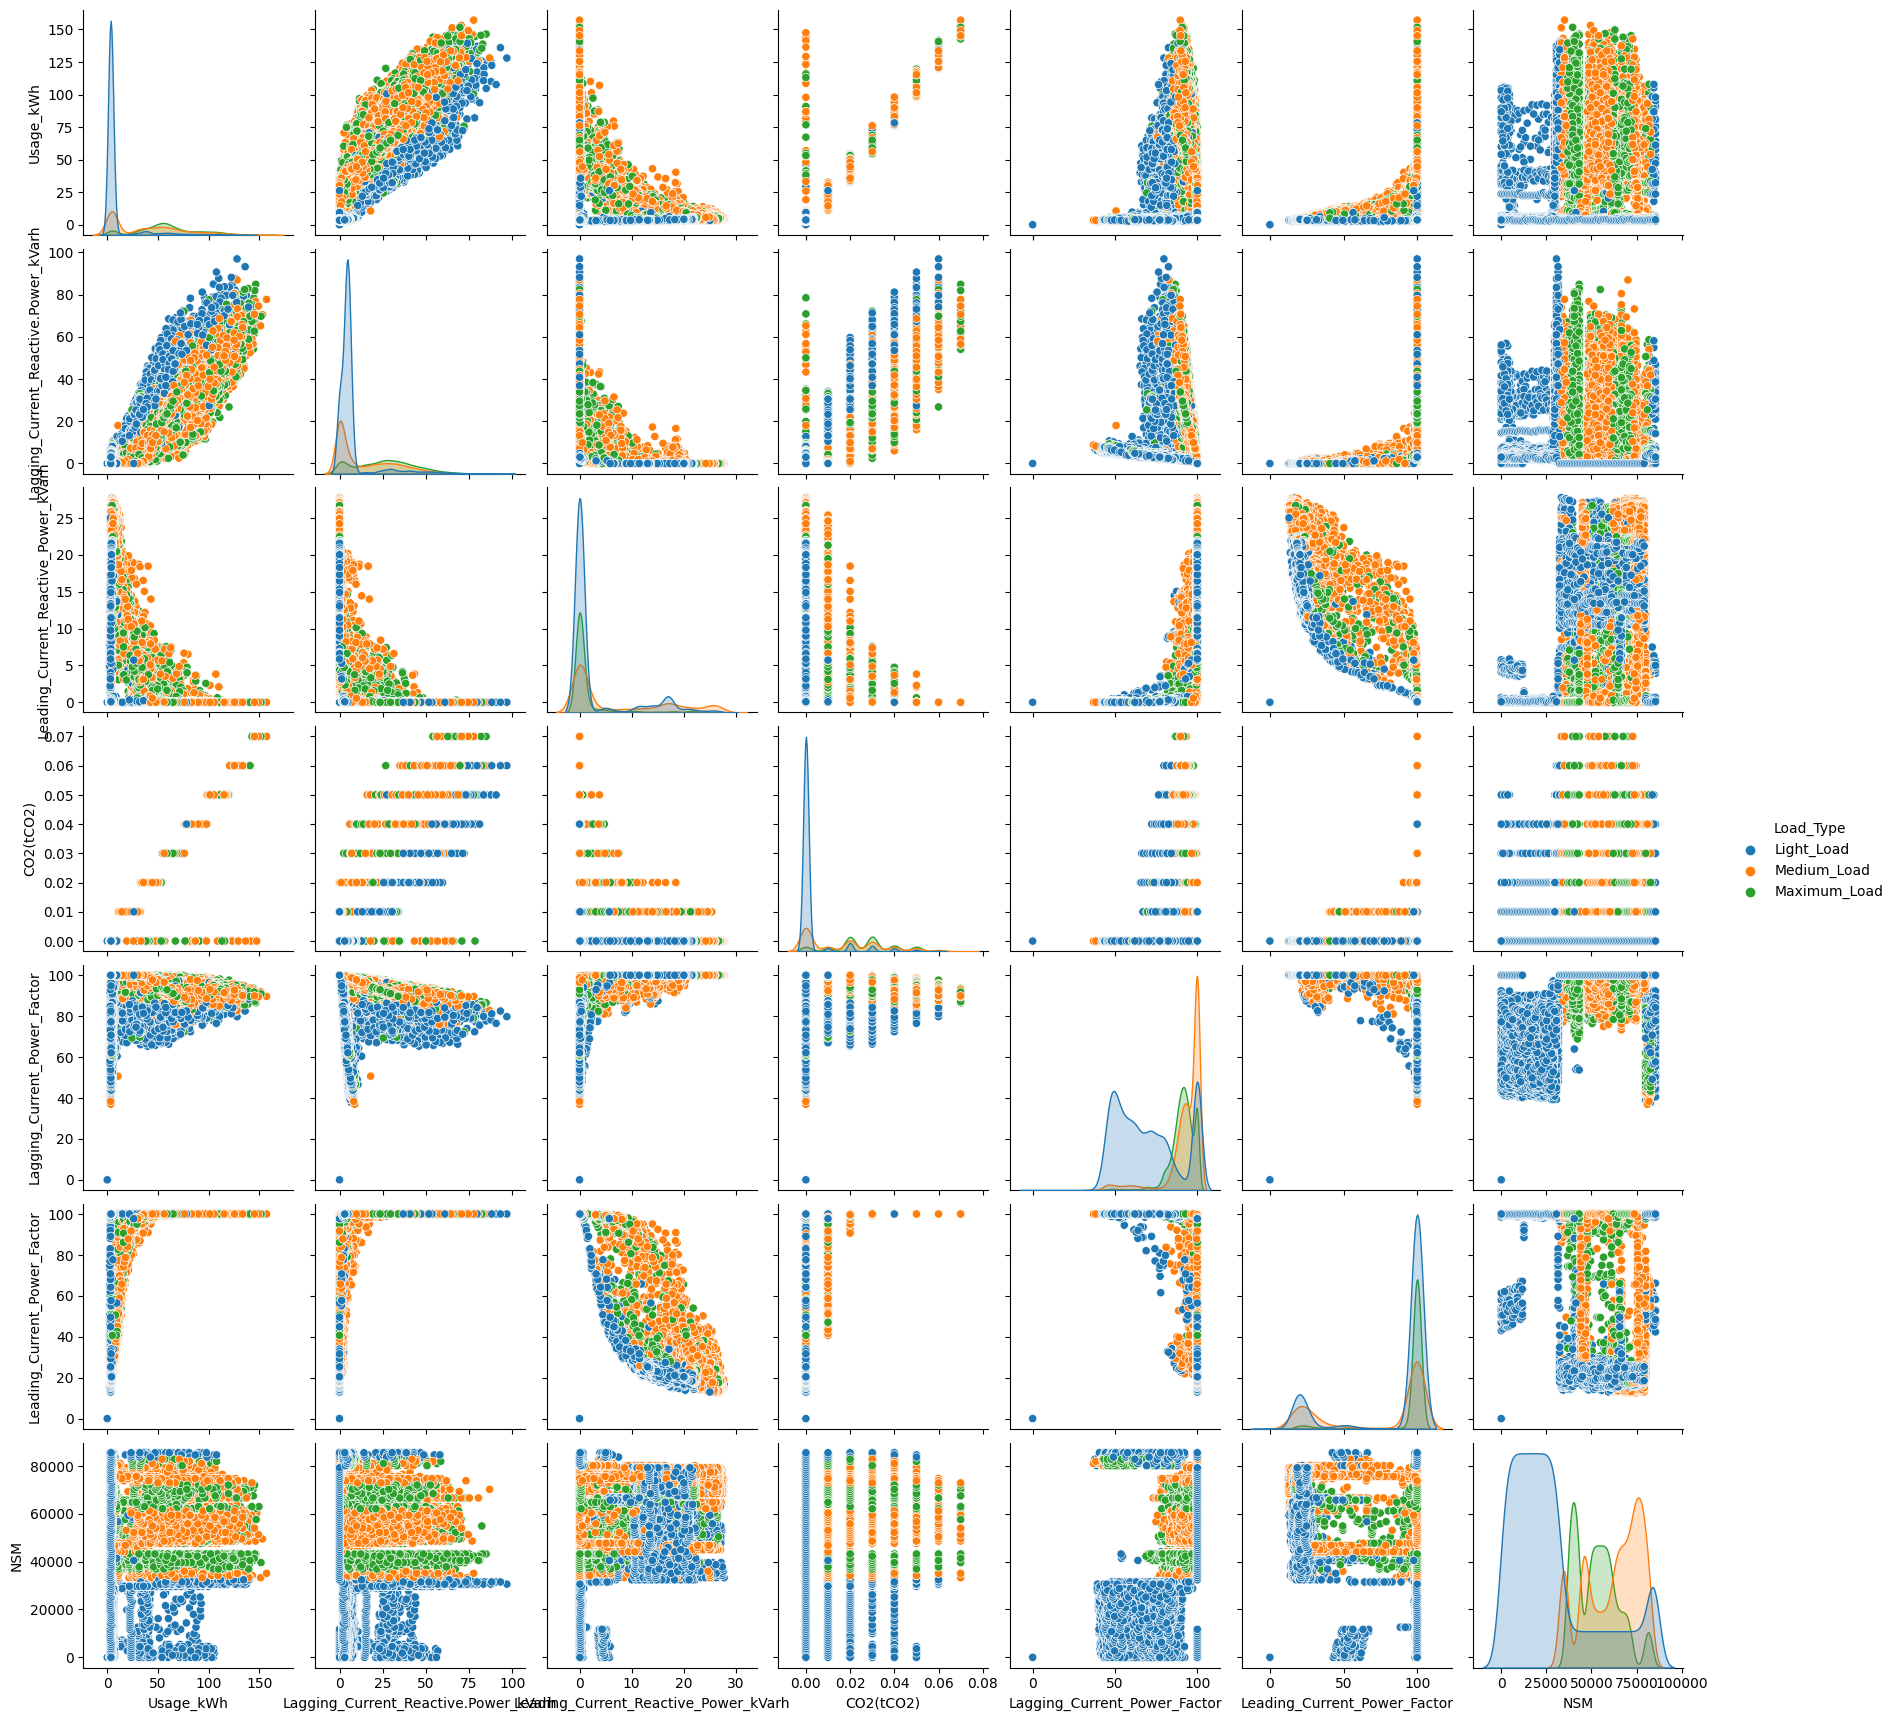

In [10]:
sns.pairplot(df, hue='Load_Type')

> A continuación se presenta una descripción de los valores estocásticos del Dataset

In [16]:
#Gráficos del EDA
### START CODE HERE ###

df.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


> También podemos ver el box plot de una columna que nos interese, por ejemplo, la del target (Usage_kWh).

<Axes: >

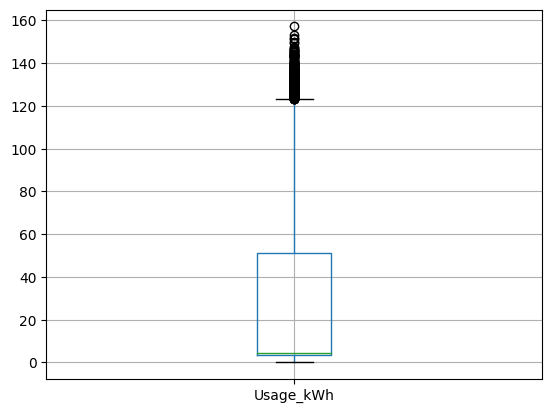

In [28]:
df[['Usage_kWh']].boxplot()

> Podemos apreciar un número alto de *outliers* en el target de nuestros datos, lo cual puede llegar a provocar malos desempeños en la red que desarrollaremos, aunque esto último depende de la forma en que procesemos nuestros datos y regularizemos el modelo.

> Junto a esto último, podemos analizar con mayor profundidad la distribución de los valores del target a través de un histograma.

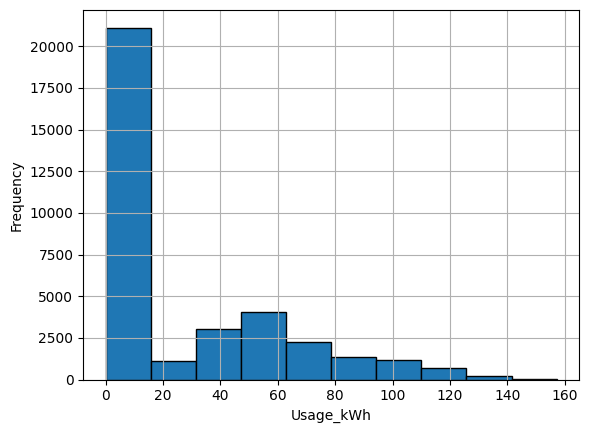

In [30]:
# Create a histogram with the target variable on the x-axis
plt.hist(df["Usage_kWh"], bins=10, edgecolor='k')

# Customize the plot
plt.xlabel("Usage_kWh")
plt.ylabel("Frequency")
plt.grid(True)

# Display the plot
plt.show()

> Podemos observar de que la mayoría de valores se concentran en el rango de 0 y 20. Esto también puede representar un punto negativo para el entrenamiento de nuestro modelo, pues tendremos poca representativdad de todo el otro espectro de valores, pudiendo obtener sets de entrenamiento y de prueba desbalanceados.

> A continuación vamos a generar un heat-map que muestra la matriz de correlación entre las variables numéricas del dataset.

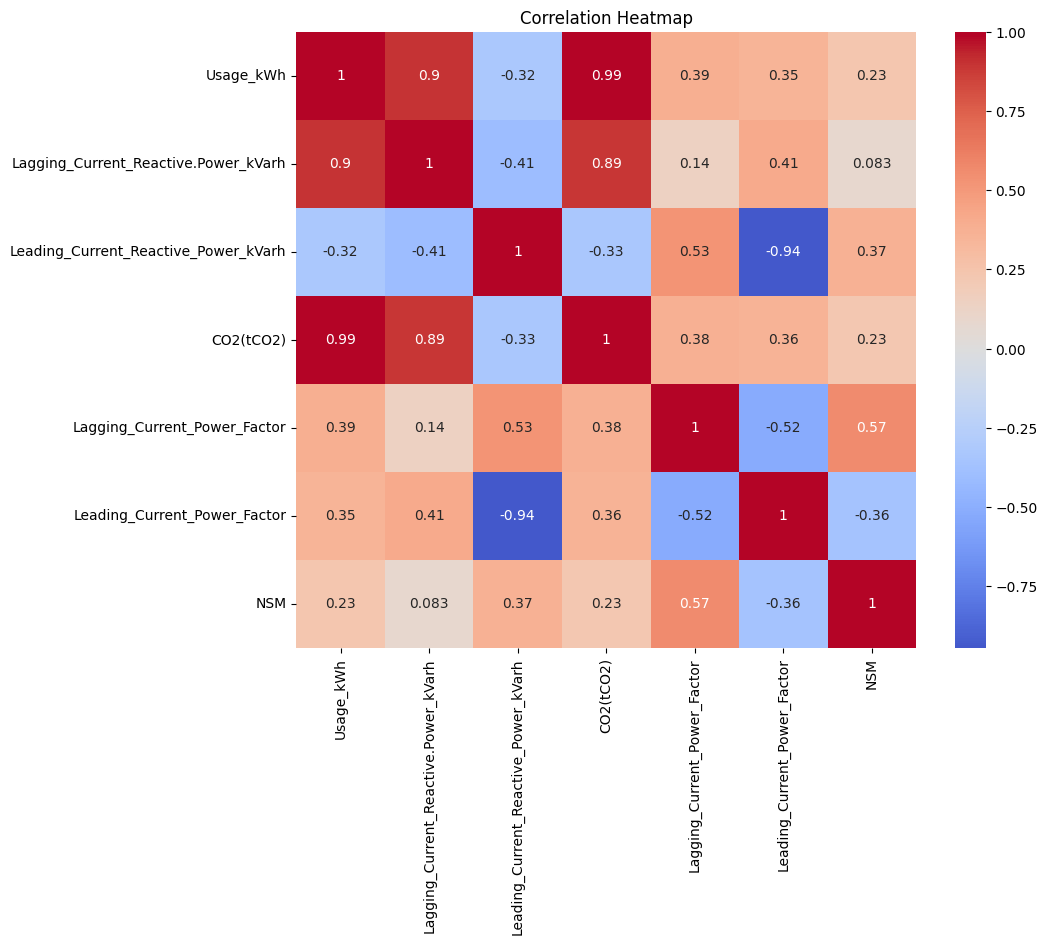

In [27]:
# Convert the date-time column to datetime data type with the correct format
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

# Remove non-numeric columns (e.g., 'Weekday') from the DataFrame
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

> Con esto obtenemos resultados interesantes. Lo primero a notar es que los *features* "CO2(tCO2)" y "Lagging_Current_Reactive.Power_kVarh" poseen una alta correlación con el target "Usage_kWh". Esto puede ser una señal de que nuestro modelo tendrá buenos resultados al considerar estos datos dentro del entrenamiento, pues será "fácil" obtener los valores reales del target respecto a estas dos variables.

### 2.2 Preprocesamiento

El proceso típico de entrenamiento de un modelo consta de dividir la data en 3 conjuntos, uno para entrenamiento, otro para validación y otro para testing

**Defina cuál es la utilidad de cada uno de estos conjuntos e implemente el código para separar la data considerando un split de 80/10/10 respectivamente** [3 Pts]

*80% de la data para entrenamiento, 10% para validación y el 10% para testing*

*Para ello se puede apoyar en la función [train_test_split](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) de scikit-learn.*

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size="size_for_test", random_state=SEED)
```
```
# Using a pandas dataframe
df_train, df_test = train_test_split(df_data, test_size="size_for_test", random_state=SEED)
```

In [123]:
# Dividir la data considerando el split indicado anteriormente (se recomienda separar en train y test en esta sección, y separar en validación en la sección de entrenamiento)
### START CODE HERE ###
# Define the random seed for reproducibility
SEED = 42

df_train, df_test = train_test_split(df, test_size = 0.1, train_size = 0.9, random_state = SEED)


*   `Training`: Como el nombre lo dice, el training set se utiliza para entrenar al modelo. La red neuronal itera sobre los ejemplos de entrenamiento y aprende a detectar patrones para generar una función predictiva del output final basado en los inputs entregados.
*   `Validation`: El conjunto de validación se utiliza durante el proceso de entrenamiento para entregar una evaluación de la performance del modelo al predecir el output cuando se le entregan inputs distintos a los del training set; ayuda a evitar el overfitting y a realizar *tuning* de hiperparámetros.
*   `Testing`: El conjunto de testing se utiliza cuando el modelo ya ha terminado su fase de entrenamiento, y evalúa el desempeño de la red neuronal al predecir el output de datos que no ha visto previamente.


### 2.3 Feature Engineering

Feature Engineering se considera un arte porque involucra mucho la creatividad con el conocimiento del dominio del problema. Consiste en el proceso de crear nuevas características o features a partir de otras existentes. En general la idea principal es la de utilizar el conocimiento del contexto del problema o bien del dominio de los datos para aprovechar esa información y crear features que puedan ayudar en el desempeño de un algoritmo, si bien existen técnicas más o menos estándar como lo puede ser normalizar o estandarizar valores numéricos tambien existen otras transformaciones que no son tan simples y varían mucho dependiendo del problema.

[Referencia](https://elitedatascience.com/feature-engineering)

#### Standard Techniques

Como se ha mencionado anteriormente existen técnicas bastante conocidas en la actualidad para abordar el apartado de Feature Engineer donde la mayoría de estas se pueden dividir en dos grandes grupos dependiendo del tipo de datos tengamos:

1.   Variables numéricas
2.   Variables categóricas

#### Numerical values

*   Normalizing: `MinMaxScaler `
*   Standarizing: `StandardScaler`

#### Categorical values

*   `One-Hot Encoding.`
*   `Ordinal Encoding.`
*   `Label Encoding.`





**Observe el siguiente código y comente cuál podría ser su utilidad para una variable relacionada con fechas, como lo puede ser un día** [2 Pts]

In [75]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [68]:
# Crear un dataframe de muestra y aplicar la función
df_day = pd.DataFrame(data=np.arange(1, 366), columns=["day"])
df_day = preprocess_time(df_day, "day", 365)
df_day.head()

,sin_day,cos_day
0,0.017213,0.999852
1,0.034422,0.999407
2,0.051620,0.998667
3,0.068802,0.997630
4,0.085965,0.996298


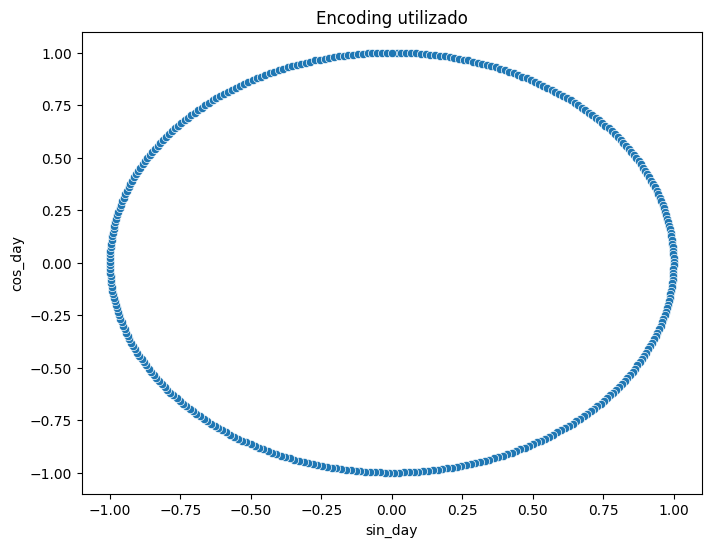

In [57]:
# Mostrar la transformación aplicada
fig = plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_day, x="sin_day", y="cos_day").set_title("Encoding utilizado")

plt.show()

`Respuesta`: El código define una función de pre-procesamiento que toma una columna con los días del año, y mediante una operación seno y coseno, les asigna a cada uno de los días un valor equivalente a un ángulo dentro de la circunferencia, para así poder extraer información más acertada respecto de las propiedades cíclicas de estas variables.

**Defina o explique la transformación que aplica cada uno de los siguientes encoding e indique la diferencia entre ellos considerando sklearn** [3 Pts]




*   `One-Hot Encoding`: One-Hot encoding codifica los datos dándoles una representación binaria, de forma que en cada momento, solo una de las variables sea leída como "verdadera" (1), y todas las otras tengan un valor de 0. Es una forma de convertir la información categórica a un formato que se le pueda entregar a un modelo de machine learning.
*   `Ordinal Encoding`: En este tipo de codificación, los datos son transformados a un formato numérico, donde los valores asignados consideran la relacion ordinal entre los datos originales del conjunto. Ordinal Encoding solo debe usarse cuando existe una relación entre las categorías a clasificar; por ejemplo, no es recomensable utilizarlo para codificar un conjunto de variables nominales.
*   `Label Encoding`: Este tipo de codificación es bastante simple; consiste en asignarle a cada una de las variables con valores categóricos un número que la represente. Es decir, es la transformación de valores categóricos a valores numéricos.

**Aplique las siguientes técnicas de preprocesamiento para cada feature especificado:** [3 Pts]

*   `MinMaxScaler` con rango (0, 1): `CO2(tCO2)`, `NSM`
*   `StandardScaler`: `Lagging_Current_Reactive.Power_kVarh`, `Leading_Current_Reactive_Power_kVarh`, `Lagging_Current_Power_Factor`, `Leading_Current_Power_Factor`
*   `Ordinal Encoding`: `Load_Type`
*   `One-Hot Encoding`: `WeekStatus`
*   `Label Encoding`: `Day_of_week`

Por último separe en `dia`, `mes` y `hora` la columna `date` y aplique la transformación cíclica a las nuevas columnas (con el periodo correspondiente para cada una).

In [124]:
# preprocesamiendo indicado
### START CODE HERE ###
# Create an instance of MinMaxScaler
co2_scaler = MinMaxScaler()
nsm_scaler = MinMaxScaler()

# Fit and transform the specified columns using MinMaxScaler on the train df,
# and then only transforming directly in the test set.
df_train['CO2(tCO2)'] = co2_scaler.fit_transform(df_train[['CO2(tCO2)']])
df_train['NSM'] = nsm_scaler.fit_transform(df_train[['NSM']])

df_test['CO2(tCO2)'] = co2_scaler.transform(df_test[['CO2(tCO2)']])
df_test['NSM'] = nsm_scaler.transform(df_test[['NSM']])


# Create an instance of StandardScaler
lacrpk_stan_sclr = StandardScaler()
lecrpk_stan_sclr = StandardScaler()
lacpf_stan_sclr = StandardScaler()
lecpf_stan_sclr = StandardScaler()

# Fit and transform the specified columns using StandardScaler, applying the same logic
# than before.
df_train['Lagging_Current_Reactive.Power_kVarh'] = lacrpk_stan_sclr.fit_transform(df_train[['Lagging_Current_Reactive.Power_kVarh']])
df_train['Leading_Current_Reactive_Power_kVarh'] = lecrpk_stan_sclr.fit_transform(df_train[['Leading_Current_Reactive_Power_kVarh']])
df_train['Lagging_Current_Power_Factor'] = lacpf_stan_sclr.fit_transform(df_train[['Lagging_Current_Power_Factor']])
df_train['Leading_Current_Power_Factor'] = lecpf_stan_sclr.fit_transform(df_train[['Leading_Current_Power_Factor']])

df_test['Lagging_Current_Reactive.Power_kVarh'] = lacrpk_stan_sclr.transform(df_test[['Lagging_Current_Reactive.Power_kVarh']])
df_test['Leading_Current_Reactive_Power_kVarh'] = lecrpk_stan_sclr.transform(df_test[['Leading_Current_Reactive_Power_kVarh']])
df_test['Lagging_Current_Power_Factor'] = lacpf_stan_sclr.transform(df_test[['Lagging_Current_Power_Factor']])
df_test['Leading_Current_Power_Factor'] = lecpf_stan_sclr.transform(df_test[['Leading_Current_Power_Factor']])


# Create an instance of Ordinal Encoder
ord_enc = OrdinalEncoder()

# Fit and transform the specified columns using Ordinal Encoder, applying the same logic
# than before.
df_train['Load_Type'] = ord_enc.fit_transform(df_train[['Load_Type']])

df_test['Load_Type'] = ord_enc.transform(df_test[['Load_Type']])


# Create an instance of One-Hot Encoder
onehot_enc = OneHotEncoder()

# Fit and transform the specified column using One-Hot Encoder, applying the same logic
# than before.
# Convert the sparse matrix to a dense array and update the DataFrame column
df_train['WeekStatus'] = onehot_enc.fit_transform(df_train[['WeekStatus']]).toarray()

df_test['WeekStatus'] = onehot_enc.transform(df_test[['WeekStatus']]).toarray()


# Create an instance of Label Encoder
lab_enc = LabelEncoder()

# Fit and transform the specified columns using Ordinal Encoder
df_train['Day_of_week'] = lab_enc.fit_transform(df_train[['Day_of_week']])

df_test['Day_of_week'] = lab_enc.transform(df_test[['Day_of_week']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [125]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Extract day, month, and hour
df_train['day'] = df_train['date'].dt.day
df_test['day'] = df_test['date'].dt.day

df_train['month'] = df_train['date'].dt.month
df_test['month'] = df_test['date'].dt.month

df_train['hour'] = df_train['date'].dt.hour
df_test['hour'] = df_test['date'].dt.hour

# Apply sin/cos transformation
df_train = preprocess_time(df_train, "day", 30)
df_train = preprocess_time(df_train, "month", 12)
df_train = preprocess_time(df_train, "hour", 24)

df_test = preprocess_time(df_test, "day", 30)
df_test = preprocess_time(df_test, "month", 12)
df_test = preprocess_time(df_test, "hour", 24)

# Delete old date feature
df_train.drop("date", axis=1, inplace=True)
df_test.drop("date", axis=1, inplace=True)

In [126]:
df_train.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,sin_day,cos_day,sin_month,cos_month,sin_hour,cos_hour
14833,5.00,-0.799577,2.603502,0.0,1.025560,-2.078090,0.526316,1.0,1,2.0,0.951057,0.309017,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000
7974,3.06,-0.582954,-0.522085,0.0,-0.799566,0.513479,0.073684,0.0,3,0.0,-0.866025,0.500000,1.000000e+00,6.123234e-17,2.588190e-01,0.965926
25807,2.74,-0.799577,1.052823,0.0,1.025560,-2.020646,0.842105,1.0,6,0.0,-0.743145,0.669131,-1.000000e+00,-1.836970e-16,-8.660254e-01,0.500000
5987,3.28,-0.799577,1.237235,0.0,1.025560,-1.970094,0.378947,0.0,3,0.0,0.587785,0.809017,8.660254e-01,-5.000000e-01,7.071068e-01,-0.707107
15757,2.99,-0.538770,-0.522085,0.0,-1.220667,0.513479,0.147368,1.0,4,0.0,0.207912,-0.978148,1.224647e-16,-1.000000e+00,7.071068e-01,0.707107


In [127]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31536 entries, 14833 to 15795
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             31536 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  31536 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  31536 non-null  float64
 3   CO2(tCO2)                             31536 non-null  float64
 4   Lagging_Current_Power_Factor          31536 non-null  float64
 5   Leading_Current_Power_Factor          31536 non-null  float64
 6   NSM                                   31536 non-null  float64
 7   WeekStatus                            31536 non-null  float64
 8   Day_of_week                           31536 non-null  int64  
 9   Load_Type                             31536 non-null  float64
 10  sin_day                               31536 non-null  float64
 11  cos_day    

In [128]:
df_train.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,sin_day,cos_day,sin_month,cos_month,sin_hour,cos_hour
count,31536.000000,3.153600e+04,3.153600e+04,31536.000000,3.153600e+04,3.153600e+04,31536.000000,31536.000000,31536.000000,31536.000000,3.153600e+04,31536.000000,3.153600e+04,3.153600e+04,3.153600e+04,3.153600e+04
mean,27.402469,-9.012465e-19,-4.573826e-17,0.164660,7.408246e-16,1.507335e-16,0.499511,0.715531,2.997939,0.762018,4.204240e-03,0.013552,-6.451314e-03,-3.246675e-03,-5.811300e-05,-6.440432e-04
std,33.455079,1.000016e+00,1.000016e+00,0.230714,1.000016e+00,1.000016e+00,0.291472,0.451168,2.001116,0.857889,7.024621e-01,0.711602,7.055958e-01,7.086001e-01,7.075614e-01,7.066740e-01
min,0.000000,-7.995768e-01,-5.220855e-01,0.000000,-4.264660e+00,-2.769066e+00,0.000000,0.000000,0.000000,0.000000,-9.945219e-01,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.200000,-6.602755e-01,-5.220855e-01,0.000000,-9.117184e-01,5.029750e-01,0.242105,0.000000,1.000000,0.000000,-7.431448e-01,-0.669131,-8.660254e-01,-8.660254e-01,-7.071068e-01,-7.071068e-01
50%,4.570000,-4.927457e-01,-5.220855e-01,0.000000,3.899402e-01,5.134792e-01,0.494737,1.000000,3.000000,0.000000,5.665539e-16,0.104528,-2.449294e-16,-1.836970e-16,1.224647e-16,-1.836970e-16
75%,51.190000,5.922088e-01,-2.367175e-01,0.285714,9.758320e-01,5.134792e-01,0.747368,1.000000,5.000000,2.000000,7.431448e-01,0.669131,5.000000e-01,8.660254e-01,7.071068e-01,7.071068e-01
max,157.180000,5.147422e+00,3.214620e+00,1.000000,1.025560e+00,5.134792e-01,1.000000,1.000000,6.000000,2.000000,9.945219e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### 2.4 Datos a predecir

Una vez teniendo nuestro dataset preprocesado toca crear un modelo de redes neuronales para predecir, para esto vamos a separar nuestro vector de entrada de la columna a predecir

In [129]:
# Separar la columna a predecir "Usage_kWh" y los datos para entrenar
### START CODE HERE ###
y_train = df_train['Usage_kWh']
X_train = df_train.drop('Usage_kWh', axis=1)  # Drop the target column from the feature set

y_test = df_test['Usage_kWh']
X_test = df_test.drop('Usage_kWh', axis=1)  # Drop the target column from the feature set

In [130]:
X_train.isna().sum()

Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
sin_day                                 0
cos_day                                 0
sin_month                               0
cos_month                               0
sin_hour                                0
cos_hour                                0
dtype: int64

### 2.5 Mi primera Red Neuronal

Ahora procederemos a crear nuestro modelo con Keras, aca queda a libre elección si quieren utilizar la API secuencial o funcional, y tambien queda a libre elección la arquitectura de la red, pruebe con distintas capas, distinto número de neuronas, distintas funciones de activación, regularizadores, etc.

In [139]:
#Crear un modelo de Keras a libre elección
### START CODE HERE ###
inputs = keras.layers.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(512, activation='relu')(inputs)
x = keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dense(16, activation='relu', kernel_initializer="he_normal")(x)

output = keras.layers.Dense(1, activation='relu')(x)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 15)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_14 (Dense)                │ (None, 512)               │      8,192 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_15 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_18 (Dense)                │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_19 (Dense)                │ (None, 16)                │        528 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 1)                 │         17 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 183,297 (716.00 KB)

 Trainable params: 183,297 (716.00 KB)

 Non-trainable params: 0 (0.00 B)

**Siendo un problema de regresión, ¿cuántas neuronas en la capa de salida tiene que tener nuestro modelo? y con que activación? [3pts]**

`Respuesta`: La capa de salida para este modelo debe tener solamente una neurona, y con una función de activación lineal.

Ahora vamos a compilar y entrenar nuestro modelo, si quiere ponerse más creativo en esta sección puede implementar callbacks, probar distintos optimizadores, batch_size y epochs.

In [140]:
### START CODE HERE ###
loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-4)

model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error", "mean_absolute_error", "root_mean_squared_error"])

In [141]:
### START CODE HERE ###
# Hiperparámetros
epochs = 200
batch_size = 500
val_split = 0.1
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

### 2.6 Entrenando el Modelo

In [142]:
### START CODE HERE ###
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 1853.7914 - mean_absolute_error: 27.0825 - mean_squared_error: 1853.8043 - root_mean_squared_error: 43.0535 - val_loss: 1743.3734 - val_mean_absolute_error: 24.5452 - val_mean_squared_error: 1694.8188 - val_root_mean_squared_error: 41.1682
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1477.9714 - mean_absolute_error: 23.7418 - mean_squared_error: 1478.0347 - root_mean_squared_error: 38.4061 - val_loss: 801.5786 - val_mean_absolute_error: 21.9896 - val_mean_squared_error: 778.4313 - val_root_mean_squared_error: 27.9004
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 601.1497 - mean_absolute_error: 19.4707 - mean_squared_error: 601.1890 - root_mean_squared_error: 24.4461 - val_loss: 181.7673 - val_mean_absolute_error: 9.2352 - val_mean_squared_error: 175.4769 - val_root_mean_squared_error: 13.2468
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 122.0177 - mean_absolute_error: 7.4302 - mean_s

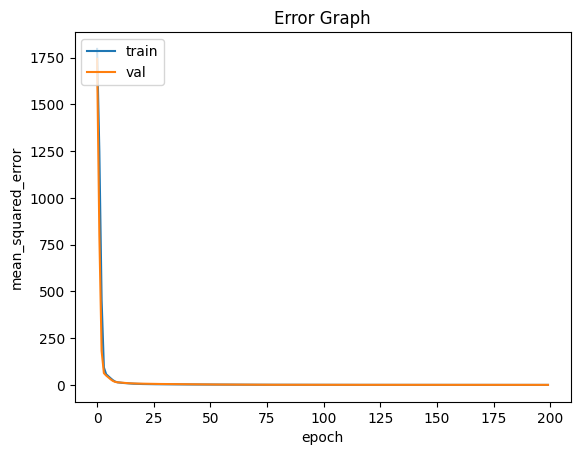

In [143]:
plot_losses(history, loss)

In [144]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6638433337211609
Test accuracy: 0.3877491056919098


In [145]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Squared Error: 0.6652313945197696


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


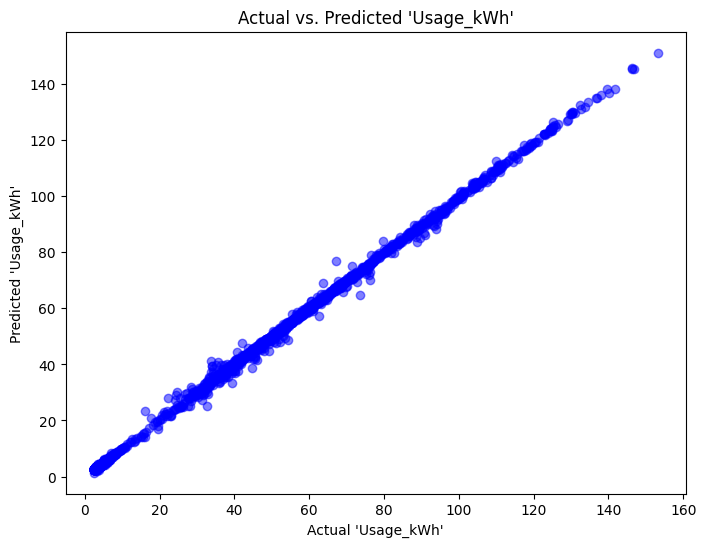

In [146]:
y_pred = model.predict(X_test)  # Predicted values

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.title("Actual vs. Predicted 'Usage_kWh'")
plt.xlabel("Actual 'Usage_kWh'")
plt.ylabel("Predicted 'Usage_kWh'")
plt.show()

> Como conclusión, se obtuvo un modelo que predice de manera satisfactoria el target, como se puede ver en el gráfico de predicción versus real, como también en el MSE obtenido, el cual es bajo para el rango de valores que abarcaba este target (0 a 160).

### 2.7 Exportar y guardar el Modelo

Por último, una vez entrenado nuestro modelo es importante guardarlo, para esto utilizaremos la función `save_model` de keras

In [147]:
model.save('steel_ind_regression.keras')

Para la entrega de la tarea, el modelo creado tiene que ser subido junto al jupyter notebook completado al github, ya sea en .keras o en un archivo .zip, el modelo será cargado y evaluado para comprobar su correcto funcionamiento, se recomienda probar el guardar y cargar el modelo en el mismo notebook para verificar que no hayan errores.

In [150]:
# Testeando carga con archivo guardado

model = keras.models.load_model('steel_ind_regression.keras')

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


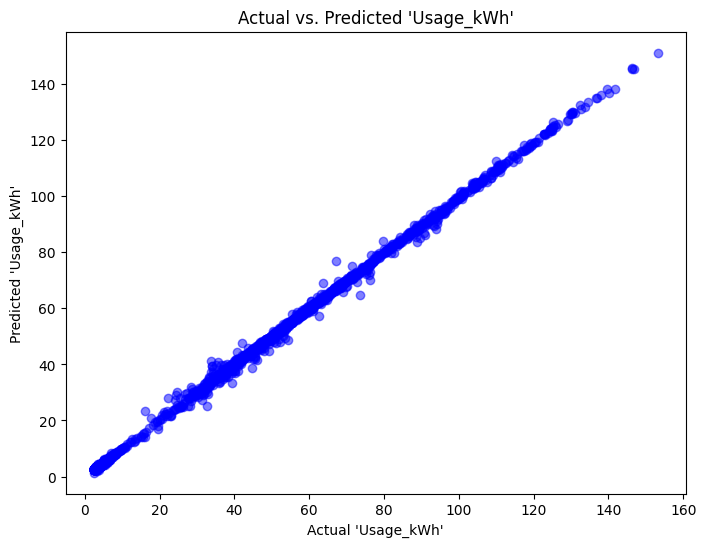

In [151]:
y_pred = model.predict(X_test)  # Predicted values

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.title("Actual vs. Predicted 'Usage_kWh'")
plt.xlabel("Actual 'Usage_kWh'")
plt.ylabel("Predicted 'Usage_kWh'")
plt.show()